<a href="https://colab.research.google.com/github/phamxuansang241/BTL-KTLT/blob/main/missing_data_gibb_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

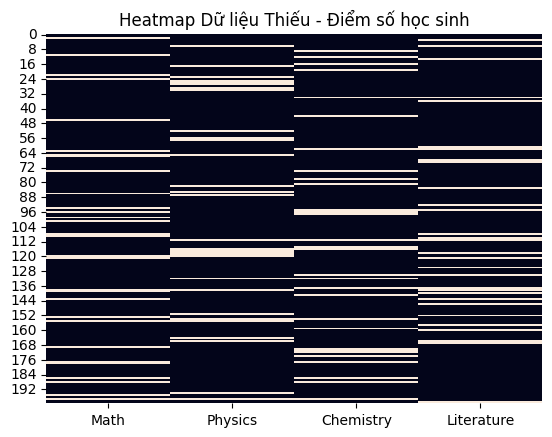

Hoàn tất Gibbs Sampling.


In [ ]:
# Import thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wishart, multivariate_normal

# 1. Sinh dữ liệu đầy đủ
np.random.seed(42)
n, p = 200, 4  # 200 học sinh, 4 môn học

mu_true = np.array([70, 65, 68, 75])  # Điểm trung bình thật
Sigma_true = np.array([
    [100, 60, 50, 30],
    [60, 120, 55, 40],
    [50, 55, 90, 20],
    [30, 40, 20, 80]
])  # Ma trận hiệp phương sai

Y_full = np.random.multivariate_normal(mu_true, Sigma_true, size=n)
columns = ['Math', 'Physics', 'Chemistry', 'Literature']
Y_full_df = pd.DataFrame(Y_full, columns=columns)

# Cắt điểm về trong khoảng 0-100
Y_full_df = Y_full_df.clip(lower=0, upper=100)

# 2. Tạo dữ liệu thiếu
Y_missing = Y_full_df.copy()
missing_rate = 0.15

np.random.seed(7)
for col in Y_missing.columns:
    missing_indices = np.random.choice(Y_missing.index, size=int(missing_rate * n), replace=False)
    Y_missing.loc[missing_indices, col] = np.nan

# Vẽ heatmap dữ liệu thiếu
sns.heatmap(Y_missing.isnull(), cbar=False)
plt.title("Heatmap Dữ liệu Thiếu - Điểm số học sinh")
plt.show()

# 3. Đặt prior và khởi tạo

# Các prior
mu0 = np.array([70, 65, 68, 75])
sd0 = np.array([20, 20, 20, 20])
L0 = 0.1 * np.ones((p, p))
np.fill_diagonal(L0, 1)
L0 = L0 * np.outer(sd0, sd0)
nu0 = p + 2
S0 = L0.copy()

# Impute missing ban đầu bằng mean
Y_imp = Y_missing.copy()
for col in Y_imp.columns:
    Y_imp[col] = Y_imp[col].fillna(Y_imp[col].mean())
Y_imp = Y_imp.values

# Mặt nạ đã quan sát
O = ~np.isnan(Y_missing.values)

# Hàm lấy mẫu từ inverse-Wishart
def invwishart_rvs(df, scale):
    W = wishart.rvs(df=df, scale=np.linalg.inv(scale))
    return np.linalg.inv(W)

# 4. Gibbs Sampling
S = 1000  # Số vòng lặp
np.random.seed(1)

THETA = []
SIGMA = []
Y_MISS = []

Sigma = S0.copy()

for s in range(S):
    # Update theta
    ybar = np.mean(Y_imp, axis=0)
    Ln_inv = np.linalg.inv(np.linalg.inv(L0) + n * np.linalg.inv(Sigma))
    mun = Ln_inv @ (np.linalg.inv(L0) @ mu0 + n * np.linalg.inv(Sigma) @ ybar)
    theta = multivariate_normal.rvs(mean=mun, cov=Ln_inv)

    # Update Sigma
    resid = (Y_imp - theta).T
    Stheta = resid @ resid.T
    Sn = S0 + Stheta
    Sigma = invwishart_rvs(df=nu0 + n, scale=Sn)

    # Update missing data
    for i in range(n):
        obs_idx = O[i, :]
        miss_idx = ~obs_idx
        if not np.any(miss_idx):
            continue

        Sigma_aa = Sigma[np.ix_(obs_idx, obs_idx)]
        Sigma_bb = Sigma[np.ix_(miss_idx, miss_idx)]
        Sigma_ba = Sigma[np.ix_(miss_idx, obs_idx)]

        iSigma_aa = np.linalg.inv(Sigma_aa)
        beta = Sigma_ba @ iSigma_aa
        Sigma_cond = Sigma_bb - beta @ Sigma_ba.T
        theta_cond = theta[miss_idx] + beta @ (Y_imp[i, obs_idx] - theta[obs_idx])

        Y_imp[i, miss_idx] = multivariate_normal.rvs(mean=theta_cond, cov=Sigma_cond)

    # Lưu lại mẫu
    THETA.append(theta)
    SIGMA.append(Sigma.flatten())
    Y_MISS.append(Y_imp[~O])

THETA = np.array(THETA)
SIGMA = np.array(SIGMA)
Y_MISS = np.vstack(Y_MISS)

print("Hoàn tất Gibbs Sampling.")


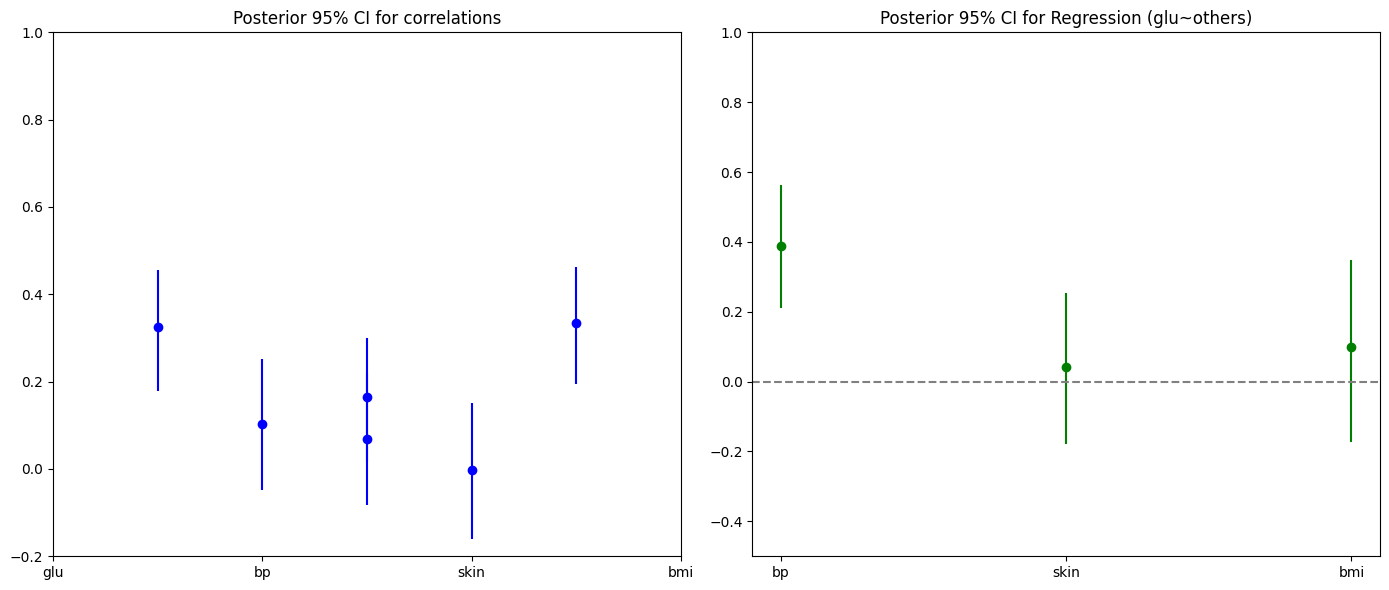

In [ ]:
plt.figure(figsize=(12,8))
for i in range(p):
    plt.plot(THETA[:,i], label=f'{columns[i]}')
plt.title('Traceplot của Theta - Điểm số học sinh')
plt.xlabel('Iteration')
plt.ylabel('Theta')
plt.legend()
plt.show()


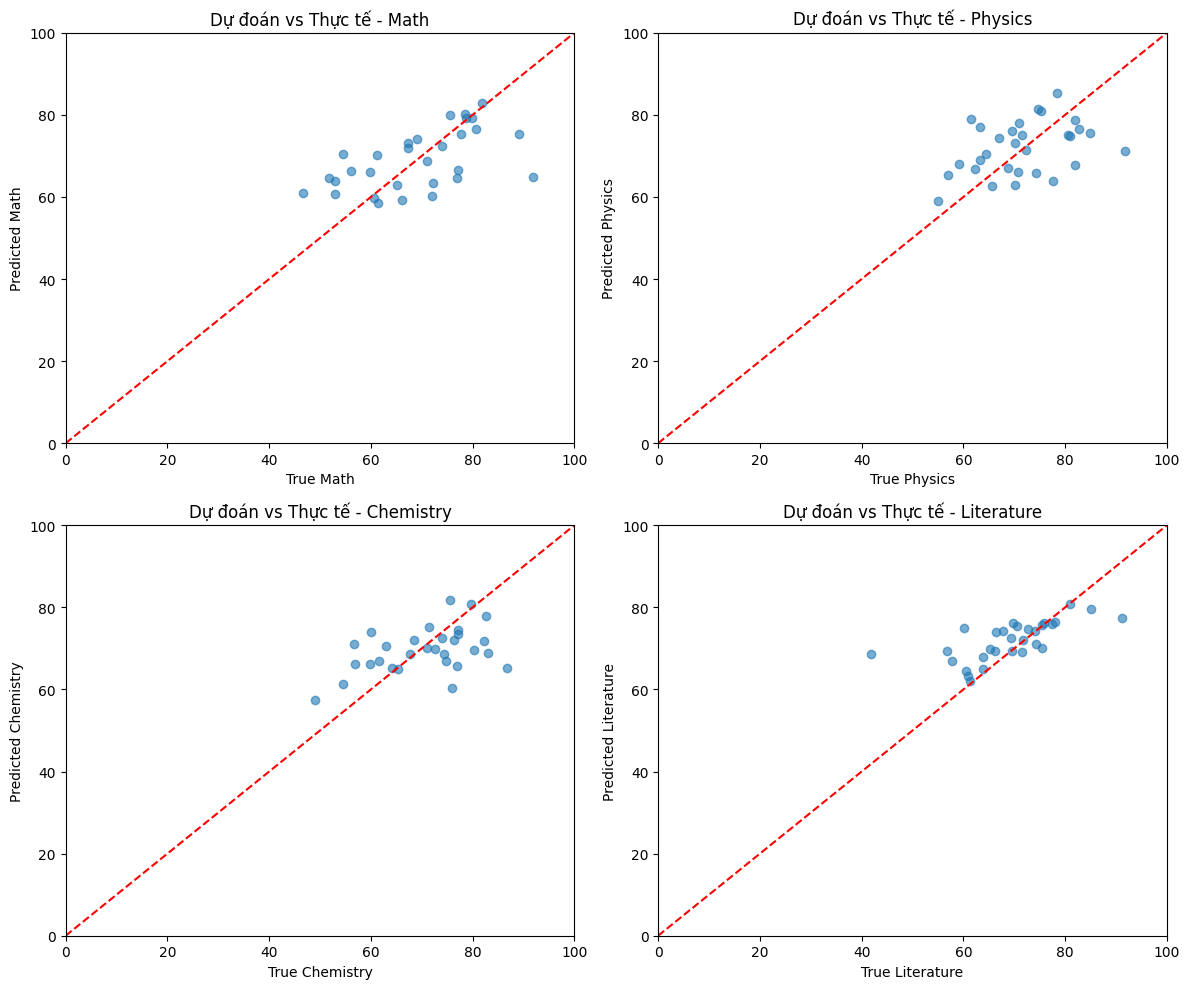

In [ ]:
true_missing = Y_full_df.values[~O]
predicted_missing = Y_MISS.mean(axis=0)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flatten()):
    idx = np.arange(i, len(true_missing), 4)
    ax.scatter(true_missing[idx], predicted_missing[idx], alpha=0.6)
    ax.plot([0, 100], [0, 100], 'r--')
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    ax.set_xlabel(f'True {columns[i]}')
    ax.set_ylabel(f'Predicted {columns[i]}')
    ax.set_title(f'Dự đoán vs Thực tế - {columns[i]}')

plt.tight_layout()
plt.show()
